In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import time
import math

from sentence_transformers import SentenceTransformer

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

c:\Users\ajwat\anaconda3\envs\python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [ ]:
writer = SummaryWriter('runs/WinTransformer')

In [14]:
SET_NAME = 'SIR'

# filename = f'{SET_NAME}_all.parquet.gz'
filename = f'{SET_NAME}_no_pad.parquet'

data = pd.read_parquet(filename)

vocab_size = data['card_selected'].max() + 1
max_pack = len(data['cards_in_pack'][0])
max_pool = len(data['cards_in_pool'][0]) + 2 # Add back 2 to max pool to account for the final 2 picks that were excluded from training
max_pool = data.iloc[:50]['cards_in_pool'].apply(len).max()

# data = data.sample(100000).reset_index(drop=True)

print('vocab_size:', vocab_size)
print('max_pool:', max_pool)
print('max_pack:', max_pack)

vocab_size: 357
max_pool: 43
max_pack: 15


In [15]:
def fix_empty_sequences(sequence):
    if len(sequence) == 0:
        sequence = np.array([1], dtype='int64')
    return sequence
              
data['cards_in_pool'] = data.apply(lambda x: fix_empty_sequences(x['cards_in_pool']), axis=1)

In [ ]:
def strip_padding(sequence):
    unpadded_len = len(sequence.nonzero()[0])
    return sequence[:unpadded_len]

data['cards_in_pool'] = data.apply(lambda x: strip_padding(x['cards_in_pool']), axis=1)

In [16]:
card_filename = f'{SET_NAME}_cards.parquet'
set_cards = pd.read_parquet(card_filename)

cf = pd.read_parquet('card_features_reduced.parquet')
cf = cf.drop_duplicates(subset='name')
cf = cf.reset_index()

features_df = pd.DataFrame({'indx':range(vocab_size)})
subset_df = set_cards[['name', 'token_id', 'id']].merge(cf, how='left', left_on='name',right_on='name')
subset_df = subset_df.drop(columns=['name','id','arena_id'])
features_df = features_df.merge(subset_df, how='left', left_on='indx', right_on='token_id')
card_feature_vectors = features_df.drop(columns=['indx','token_id','rarity_bonus']).astype(float).fillna(0).to_numpy()
card_feature_vectors = torch.from_numpy(card_feature_vectors).float()
num_features = card_feature_vectors.shape[1]

print(card_feature_vectors.shape)

torch.Size([357, 60])


In [17]:
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v1') # 384 dim
# sentence_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')  # 768 dim

sbert_df = pd.DataFrame({'indx':range(vocab_size)})
sbert_df = sbert_df.merge(set_cards[['token_id','oracle_text']], how='left', left_on='indx', right_on='token_id')

sbert_df['oracle_text'].fillna(' ', inplace=True)
card_text_list = sbert_df['oracle_text'].to_list()

card_text_embeddings = sentence_model.encode(card_text_list, normalize_embeddings=True, convert_to_tensor=True)  # 384 dims
card_text_dim = 384 

# # Zero out embeddings for game wins indicator tokens
# card_text_embeddings[-8:] = 0

print(card_text_embeddings.size())

torch.Size([357, 384])


In [18]:
from sklearn.model_selection import train_test_split

ds_train, ds_val = train_test_split(data, test_size=0.2, shuffle=True)
ds_train = ds_train.reset_index(drop=True)
ds_val = ds_val.reset_index(drop=True)

print(f'Training Size: {len(ds_train):,}\nValidation size: {len(ds_val):,}')

Training Size: 16,139
Validation size: 4,035


In [43]:
nn.Module?

Init signature: nn.Module(*args, **kwargs) -> None
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in training or
                ev

### Model

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout, max_len):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
    
class BaseTransformer(nn.Module):

    def __init__(self, vocab_size, emb_dim, text_emb_dim, num_heads, num_encoder_layers, dim_feedforward, dropout):
        super().__init__()
        self.model_type = 'Transformer'
        self.emb_dim = emb_dim
        self.text_emb_dim = text_emb_dim

        self.positional_encoder = PositionalEncoding(dim_model=emb_dim, dropout=dropout, max_len=1000)
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.project_embedding = nn.Linear((self.text_emb_dim + self.emb_dim), self.emb_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True),
            num_layers=num_encoder_layers
        )
        self.out = nn.Linear(emb_dim, vocab_size)

    def forward(self, src, logit_mask, text_embeddings):

        pad_mask = (src == 0)
        
        src = self.embedding(src.squeeze(1)) * math.sqrt(self.emb_dim)
        
        # Concat source embedding with sBERT sentence embeddings, then project back to the model's embedding dimension
        src_extended = torch.cat((src, text_embeddings), dim=2)
        src = self.project_embedding(src_extended)
        
        encoder_out = self.encoder(src, src_key_padding_mask=pad_mask)

        # Select the output for the last token in the input sequence
        last_token_output = encoder_out[:, -1:, :]  # (batch_size, emb_dim)

        # Final output layer to get logits for pick prediction
        logits = self.out(last_token_output).squeeze(1)

        # Reshape and apply logit mask
        if logit_mask.dim() == 3 and logit_mask.shape[1] == 1:
            logit_mask = logit_mask.squeeze(1)

        logits += logit_mask

        return logits

    def create_pad_mask(self, matrix, pad_token):
        return (matrix == pad_token)

### Dataset Class

In [20]:
from torch.utils.data import Dataset, DataLoader

class BaseTransformerDataset(Dataset):
    def __init__(self, df):
        self.df = df
        # Convert necessary columns to numpy arrays for quicker access
        self.cards_in_pack = df['cards_in_pack'].to_numpy()
        self.cards_in_pool = df['cards_in_pool'].to_numpy()
        self.card_selected = df['card_selected']
        # self.target_index = df['target_index'].to_numpy()
        self.game_wins = df['wins']
        self.max_pool_length = df.iloc[:50]['current_pool_with_wins'].apply(len).max()
        self.max_pack_length = len(df['cards_in_pack'][0])
        self.vocab_size = df['card_selected'].max() + 1 + 8
        self.max_pack = len(df['cards_in_pack'][0])
        self.max_pool = df.iloc[:50]['current_pool_with_wins'].apply(len).max()
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # history = torch.from_numpy(self.cards_in_pool[idx])
        # options = torch.from_numpy(self.cards_in_pack[idx])
        history = self.cards_in_pool[idx]
        options = self.cards_in_pack[idx]
        target = self.card_selected[idx]
        return history, options, target
    
def add_padding(base_tensor, padded_length):
    # Create padding on CPU, and dtype should match expected input type, usually long for indices
    padded_array = np.full((1,padded_length), 0)
    padded_array[:,:len(base_tensor)] = base_tensor
    return padded_array

def make_logit_mask(indices):
    indices = torch.tensor(indices)
    # mask  = torch.full((vocab_size,), -float('inf'))
    mask  = torch.full((vocab_size,), -1000)
    mask[indices] = 0
    return mask

def prep_text_emb(embeddings, padded_length):
    full_pad = torch.full((padded_length, embeddings.shape[-1]), 0, dtype=torch.float)
    full_pad[:embeddings.shape[0], :] = embeddings
    return full_pad

def base_transformer_collate_fn(batch):
    # Unpacking the batch
    hist_srcs, options_srcs, target = zip(*batch)

    # Find the maximum length within this batch for padding
    max_hist_length = max([s.shape[0] for s in hist_srcs])
    # max_option_length = max([s.shape[0] for s in options_srcs])
    max_len = max(max_hist_length, 0)

    # Pad the sequences in the batch
    hist_padded = [torch.tensor(add_padding(x, max_len), dtype=torch.long) for x in hist_srcs]
    options_padded = [torch.tensor(add_padding(x, max_len), dtype=torch.long) for x in options_srcs]

    # Mask for output  logits
    logit_masks = [make_logit_mask(x) for x in options_srcs]
    # Masks for text embeddings at padded positions
    text_embeddings = [prep_text_emb(card_text_embeddings[x], max_len) for x in hist_srcs]

    # Stack the sequences
    hist_stack = torch.stack(hist_padded)
    options_stack = torch.stack(options_padded)
    mask_stack = torch.stack(logit_masks).unsqueeze(1)
    target_stack = torch.tensor(target).unsqueeze(1)
    target_indices = torch.where(options_stack.squeeze() == target_stack)[1]
    text_embeddings_stack = torch.stack(text_embeddings)

    return hist_stack, mask_stack, target_stack, text_embeddings_stack



### Training Loop Functions

In [21]:

def train_loop(model, optimizer, loss_fn, dataloader, device, epoch, max_pool, scheduler=None, loss_fn_2=None, loss_scaling=False, batch_steps=None):
    model.train()
    total_train_loss = 0

    for i, batch in enumerate(dataloader):

        history_src, logit_mask, target = [x.to(device) for x in batch] 

        # Get logits from forward pass
        logits = model(history_src.squeeze(), logit_mask)

        # Record loss
        loss = loss_fn(logits, target.view(-1))        
        total_train_loss += loss.item()
        
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + i)
        writer.add_scalar('LearningRate/lr', optimizer.param_groups[0]['lr'], epoch * len(dataloader) + i)

        optimizer.zero_grad()
        loss.backward()
        # Advance Optimizer and LR Scheduler
        optimizer.step()
        scheduler(None)

        # if loss_scaling:
        #     # Scaling factor
        #     scale_factor = 2**4
        #     # Scale up the loss
        #     scaled_loss = loss * scale_factor
        #     # Backward pass on the scaled loss
        #     scaled_loss.backward()
        #     # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        #     # Scale down gradients
        #     for param in model.parameters():
        #         if param.grad is not None:
        #             param.grad /= scale_factor
        # else:
        #     optimizer.zero_grad()
        #     loss.backward()
        #     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

        # Record gradients to tensorboard
        if i % 10 == 0:
          for name, parameter in model.named_parameters():
              # writer.add_histogram(f'{name}', parameter, epoch * len(dataloader) + i)
              if parameter.grad is not None:
                  writer.add_scalar(f'Gradients/{name}', parameter.grad.norm(), epoch * len(dataloader) + i)
                  writer.add_histogram(f'{name}/grads', parameter.grad, epoch * len(dataloader) + i)

        if i % 100 == 0:
            print(f"Batch {i} of {batch_steps}, Loss {loss.item():.4f}") # , LR  {optimizer.param_groups[0]['lr']:.4f}

        if i >= batch_steps:
            break

    average_train_loss = total_train_loss / batch_steps
    return average_train_loss


def validate_loop(model, loss_fn, dataloader, device, epoch, max_pool):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_predictions = 0
    correct_top_2 = 0
    correct_top_3 = 0
    total_predictions = 0

    with torch.no_grad():  # No gradient computation for validation
        for batch in dataloader:
            history_src, logit_mask, target = [x.to(device) for x in batch] 

            # Get logits from forward pass
            logits = model(history_src.squeeze(), logit_mask)

            # Record loss
            loss = loss_fn(logits, target.view(-1))    
            total_val_loss += loss.item()

            # Calculate accuracy
            _, predicted_indices = torch.max(logits, dim=-1)
            _, pred_top_2 = torch.topk(logits, 2)
            _, pred_top_3 = torch.topk(logits, 3)
            correct_predictions += (predicted_indices == target).sum().item()
            correct_top_2 += (target.unsqueeze(1) == pred_top_2).any(dim=1).sum().item()
            correct_top_3 += (target.unsqueeze(1) == pred_top_3).any(dim=1).sum().item()
            total_predictions += target.numel()

    average_loss = total_val_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    top_2_accuracy = correct_top_2 / total_predictions
    top_3_accuracy = correct_top_3 / total_predictions

    # Log loss
    writer.add_scalar('Loss/val', average_loss, epoch)
    writer.add_scalar('Accuracy/val', accuracy, epoch)
    writer.add_scalar('Accuracy/top2', top_2_accuracy, epoch)
    writer.add_scalar('Accuracy/top3', top_3_accuracy, epoch)

    return average_loss, accuracy, top_2_accuracy, top_3_accuracy



def fit(model, optimizer, loss_fn, train_dataloader, val_dataloader, device, epochs, max_pool, scheduler=None, save_path='best_model.pth', loss_fn_2=None, loss_scaling=False, batch_steps=None):

    training_losses = []
    validation_losses = []
    validation_accuracies = []
    validation_accuracies_2 = []
    validation_accuracies_3 = []
    fit_times = []
    best_val_loss = float('inf')  # Initialize the best validation loss to infinity

    for epoch in range(epochs):

        epoch_start_time = time.time()
        print(f'\nEpoch {epoch+1}')
        print('--------------------')
        # Training Phase
        train_loss = train_loop(model, optimizer, loss_fn, train_dataloader, device, epoch, max_pool, scheduler, loss_fn_2, loss_scaling, batch_steps)
        training_losses.append(train_loss)

        # Validation Phase
        val_loss, val_accuracy, val_top_2, val_top_3 = validate_loop(model, loss_fn, val_dataloader, device, epoch, max_pool)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)
        validation_accuracies_2.append(val_top_2)
        validation_accuracies_3.append(val_top_3)

        # Checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, save_path)
            print(f"Checkpoint saved")

        epoch_duration = (time.time() - epoch_start_time)
        fit_times.append(epoch_duration)
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Training Loss: {train_loss:.4f}")
        print(f"  Validation Loss: {val_loss:.4f}")
        print(f"  Validation Accuracy: {val_accuracy:.4f}")
        print(f"       Top 2 Accuracy: {val_top_2:.4f}")
        print(f"       Top 3 Accuracy: {val_top_3:.4f}")
        print(f"  Training Time: {epoch_duration:5.2f}s")

    # Close the writer
    writer.close()
    print(f"Total Training Time: {sum(fit_times):5.2f}s")
    return training_losses, validation_losses, validation_accuracies, validation_accuracies_2, validation_accuracies_3, fit_times

### Instantiate Model and DataLoader

In [22]:
# Parameters
vocab_size = vocab_size
embed_dim = 256
num_heads = 2
num_encoder_layers = 2
dim_feedforward = 512
pad_token_id = 0
batch_size = 32


# Instantiate model
model = BaseTransformer(
    vocab_size=vocab_size,
    emb_dim=embed_dim,
    text_emb_dim = card_text_dim,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)


dataset = BaseTransformerDataset(ds_train)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=base_transformer_collate_fn,
    pin_memory=False
)

val_dataset = BaseTransformerDataset(ds_val)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=base_transformer_collate_fn,
    pin_memory=False
)

n_batches = len(dataset) // batch_size


In [23]:
num_epochs=8
steps_per_epoch = 2000
total_iteration = steps_per_epoch * num_epochs

initial_lr = 3e-4
warmup_initial_lr = 1e-7
warmup_iteration = 2*steps_per_epoch

opt = torch.optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = nn.CrossEntropyLoss()

scheduler = create_lr_scheduler_with_warmup(StepLR(opt, step_size=(total_iteration // (num_epochs)), gamma=0.5),
                                               warmup_start_value=warmup_initial_lr,
                                               warmup_duration=warmup_iteration,
                                               warmup_end_value=initial_lr)
scheduler(None)


In [26]:
for batch in dataloader:
    break


history_src, logit_mask, target, text_embeddings = [x.to(device) for x in batch] 

# Get logits from forward pass>
logits = model(history_src.squeeze(), logit_mask, text_embeddings)

# Record loss
# loss = loss_fn(logits, target.view(-1))       



### Fit the Model

In [ ]:
writer = SummaryWriter('runs/BaseTransformer/Fit_1')

n_epochs = 4

save_path = f'BaseTransformer_{SET_NAME}_{embed_dim}dim_{num_encoder_layers}layers_{num_heads}heads_{n_epochs}epochs.pth'

print(save_path)

print(f'Embedding dim: {embed_dim} | Heads: {num_heads} | Encoder Layers: {num_encoder_layers} | Opt: AdamW | LR: {initial_lr}\n')

training_results = fit(model, opt, loss_fn, dataloader, val_dataloader, device, n_epochs, max_pool, scheduler=scheduler,
                       save_path=save_path)


# torchview

In [7]:
from torchview import draw_graph
import graphviz


graphviz.set_jupyter_format('png')

# model = MLP()
# batch_size = 2
# # device='meta' -> no memory is consumed for visualization
# model_graph = draw_graph(model, input_size=(batch_size, 128), device='meta')
# model_graph.visual_graph

'svg'

In [8]:
class SimpleRNN(nn.Module):
    """Simple RNN"""

    def __init__(self, inplace: bool = True) -> None:
        super().__init__()
        self.hid_dim = 2
        self.input_dim = 3
        self.max_length = 4
        self.lstm = nn.LSTMCell(self.input_dim, self.hid_dim)
        self.activation = nn.LeakyReLU(inplace=inplace)
        self.projection = nn.Linear(self.hid_dim, self.input_dim)

    def forward(self, token_embedding: torch.Tensor) -> torch.Tensor:
        b_size = token_embedding.size()[0]
        hx = torch.randn(b_size, self.hid_dim, device=token_embedding.device)
        cx = torch.randn(b_size, self.hid_dim, device=token_embedding.device)

        for _ in range(self.max_length):
            hx, cx = self.lstm(token_embedding, (hx, cx))
            hx = self.activation(hx)

        return hx


(dot.exe:14016): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


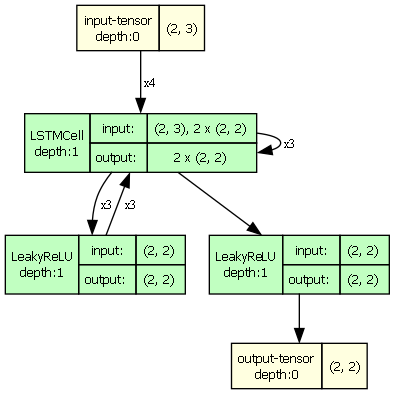

In [10]:
model_graph_1 = draw_graph(
    SimpleRNN(), input_size=(2, 3),
    graph_name='RecursiveNet',
    roll=True
)

model_graph_1.visual_graph

In [ ]:
# Parameters
vocab_size = vocab_size
embed_dim = 256
num_heads = 2
num_encoder_layers = 2
dim_feedforward = 512
pad_token_id = 0
batch_size = 32


# Instantiate model
model = BaseTransformer(
    vocab_size=vocab_size,
    emb_dim=embed_dim,
    text_emb_dim = card_text_dim,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)

In [29]:
draw_graph?

Signature:
draw_graph(
    model: 'nn.Module',
    input_data: 'INPUT_DATA_TYPE | None' = None,
    input_size: 'INPUT_SIZE_TYPE | None' = None,
    graph_name: 'str' = 'model',
    depth: 'int | float' = 3,
    device: 'torch.device | str | None' = None,
    dtypes: 'list[torch.dtype] | None' = None,
    mode: 'str | None' = None,
    strict: 'bool' = True,
    expand_nested: 'bool' = False,
    graph_dir: 'str | None' = None,
    hide_module_functions: 'bool' = True,
    hide_inner_tensors: 'bool' = True,
    roll: 'bool' = False,
    show_shapes: 'bool' = True,
    save_graph: 'bool' = False,
    filename: 'str | None' = None,
    directory: 'str' = '.',
    **kwargs: 'Any',
) -> 'ComputationGraph'
Docstring:
Returns visual representation of the input Pytorch Module with
ComputationGraph object. ComputationGraph object contains:

1) Root nodes (usually tensor node for input tensors) which connect to all
the other nodes of computation graph of pytorch module recorded during forward
p

In [ ]:
expand_nested: 'bool' = False,
    graph_dir: 'str | None' = None,
    hide_module_functions: 'bool' = True,
    hide_inner_tensors: 'bool' = True,
    roll: 'bool' = False,
    show_shapes: 'bool' = True,
    save_graph: 'bool' = False,
    filename: 'str | None' = None,


In [64]:
model_graph_1 = draw_graph(
            BaseTransformer(
                vocab_size=vocab_size,
                emb_dim=embed_dim,
                text_emb_dim = card_text_dim,
                num_heads=num_heads,
                num_encoder_layers=num_encoder_layers,
                dim_feedforward=dim_feedforward,
                dropout=0.1
),
    input_data=([history_src.squeeze(), logit_mask, text_embeddings]),
    graph_name='RecursiveNet',
    roll=True,
    expand_nested=True,
    hide_module_functions=True,
    depth=2,
    hide_inner_tensors=True,
    graph_dir='TB'
)



(dot.exe:3536): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


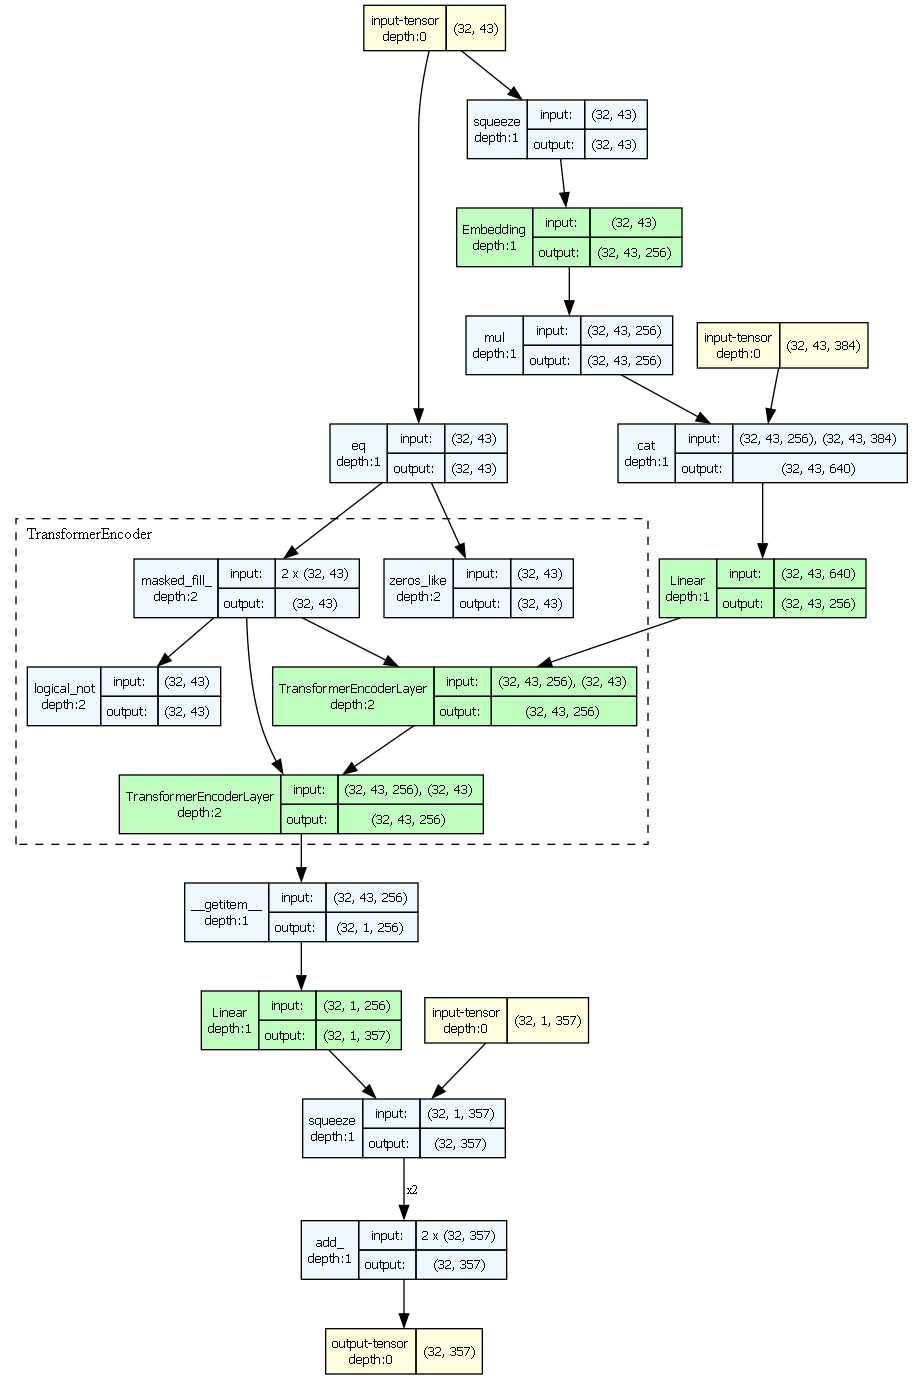

In [66]:
model_graph_1.resize_graph(scale=1.5)

model_graph_1.


(dot.exe:1960): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


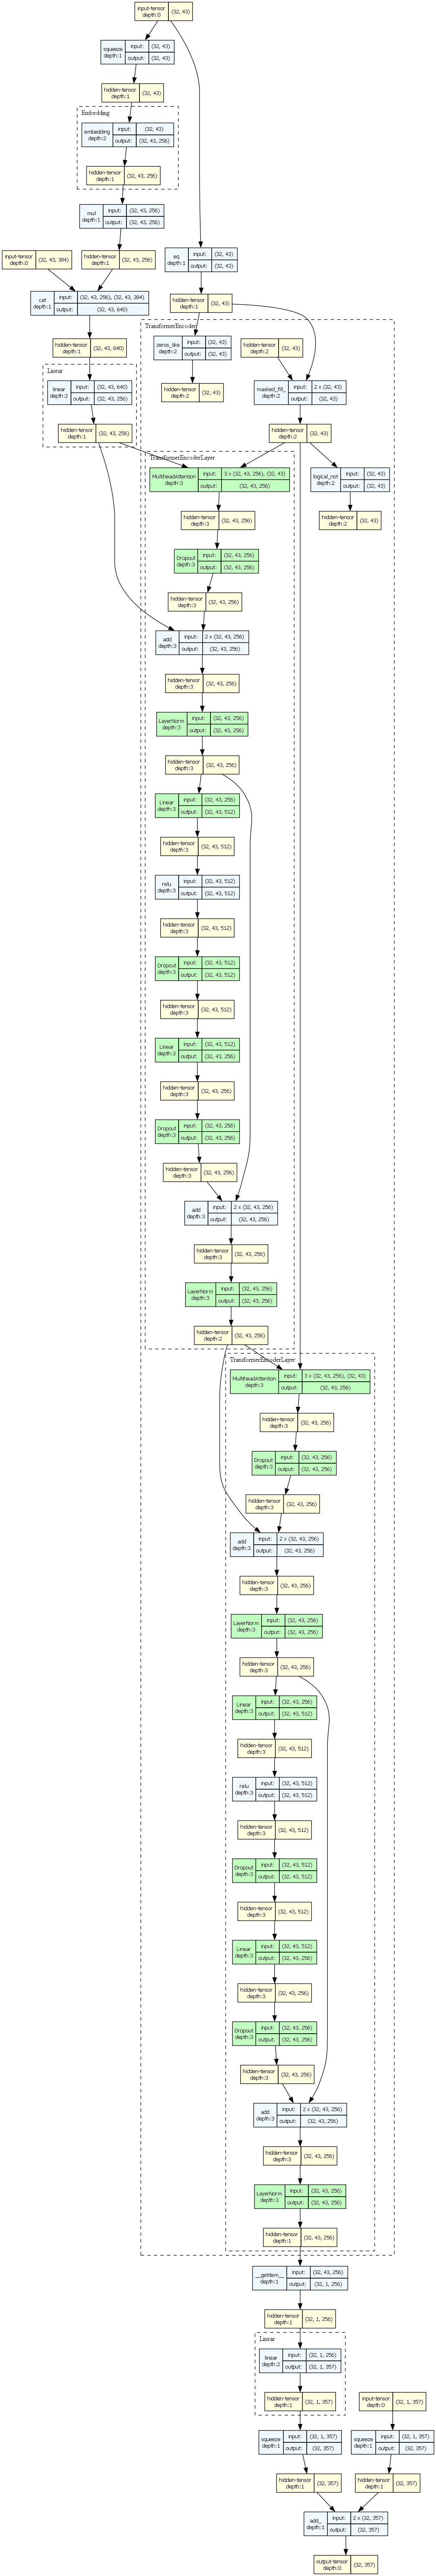

In [38]:
graphviz.set_jupyter_format('png')

'png'